In [388]:
import os
import cv2
import numpy as np
from PIL import Image
import skimage
from skimage import exposure
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from skimage.color import rgb2gray
from imgaug import augmenters as iaa

# Define paths for core and logs folders
core_path = '/Users/jexpatel/Desktop/Image Classification/Dataset/Core'
logs_path = '/Users/jexpatel/Desktop/Image Classification/Dataset/Well Log'

# Define the output path of pre-processed and augmented dataset
output_dir_core = '/Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core'
output_dir_logs = '/Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs'

In [313]:
# Function to load and review characteristics of images in a directory
def review_image_characteristics(image_dir, class_name):
    print(f'Reviewing characteristics of {class_name} images in directory: {image_dir}')
    image_filenames = os.listdir(image_dir)
    num_images = len(image_filenames)
    print(f'Total number of {class_name} images: {num_images}')

    # Initialize variables to store characteristics of images
    min_width = float('inf')
    max_width = 0
    min_height = float('inf')
    max_height = 0
    num_channels = 0
    num_color = 0
    num_grayscale = 0
    image_shapes = []

    for filename in image_filenames:
        # Load image
        img = cv2.imread(os.path.join(image_dir, filename))

        # Review image characteristics
        height, width, channels = img.shape
        min_width = min(min_width, width)
        max_width = max(max_width, width)
        min_height = min(min_height, height)
        max_height = max(max_height, height)
        num_channels = channels
        if channels == 1:
            num_grayscale += 1
        else:
            num_color += 1
        image_shapes.append((height, width))

    # Print the reviewed characteristics of images
    print(f'Minimum image width: {min_width} pixels')
    print(f'Maximum image width: {max_width} pixels')
    print(f'Minimum image height: {min_height} pixels')
    print(f'Maximum image height: {max_height} pixels')
    print(f'Number of color images: {num_color}')
    print(f'Number of grayscale images: {num_grayscale}')
    print(f'Total number of channels: {num_channels}')
    print(f'Shapes of images: {image_shapes}')
    
    return image_filenames


# Review characteristics of core images
review_core_images = review_image_characteristics(core_path, 'core')

# Review characteristics of logs images
review_logs_images = review_image_characteristics(logs_path, 'logs')

Reviewing characteristics of core images in directory: /Users/jexpatel/Desktop/Image Classification/Dataset/Core
Total number of core images: 20
Minimum image width: 3024 pixels
Maximum image width: 4032 pixels
Minimum image height: 3024 pixels
Maximum image height: 4032 pixels
Number of color images: 20
Number of grayscale images: 0
Total number of channels: 3
Shapes of images: [(3024, 4032), (4032, 3024), (4032, 3024), (3024, 4032), (4032, 3024), (4032, 3024), (4032, 3024), (4032, 3024), (4032, 3024), (4032, 3024), (4032, 3024), (4032, 3024), (4032, 3024), (4032, 3024), (4032, 3024), (4032, 3024), (3024, 4032), (4032, 3024), (4032, 3024), (3024, 4032)]
Reviewing characteristics of logs images in directory: /Users/jexpatel/Desktop/Image Classification/Dataset/Well Log
Total number of logs images: 20
Minimum image width: 961 pixels
Maximum image width: 2880 pixels
Minimum image height: 1281 pixels
Maximum image height: 3840 pixels
Number of color images: 20
Number of grayscale images: 

In [314]:
#Preprocesses images by loading, converting to grayscale, and resizing.

def preprocess(image_dir):
    images = []
    file_names = []
    for file_name in os.listdir(image_dir):
        if file_name.endswith('.jpg') or file_name.endswith('.JPG') or file_name.endswith('.tif'):
            file_path = os.path.join(image_dir, file_name)
            image = Image.open(file_path)
            images.append(image)
            file_names.append(file_name)
    
    # Convert images to grayscale (if RGB) and resize it
    images_resized = []
    img_size = (256, 256)
    
    for image in images:
        
        if image.mode != 'L':
            gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
            gray = np.expand_dims(gray, axis=-1)  # Add channel dimension
            resized_image = cv2.resize(gray, img_size)
            equalized_image = cv2.equalizeHist(resized_image)
        else:
            gray = np.expand_dims(np.array(image), axis=-1)  # Add channel dimension
            resized_image = cv2.resize(np.array(image), img_size)
            equalized_image = cv2.equalizeHist(resized_image)
        images_resized.append(resized_image)
    
    return images_resized, file_names

In [397]:
def augment(images):
    augmented_images = []
    num_augmented_images = 0
    
    # Define augmentation sequence
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),
    ])
    
    while num_augmented_images < 400:
        # Sample a random image from the dataset
        image = images[np.random.randint(len(images))]
        
        # Reshape image to have a third dimension (channels)
        image = image.reshape(image.shape[0], image.shape[1], 1)

        # Calculate image entropy
        entropy = cv2.calcHist([image], [0], None, [256], [0, 256])
        entropy = -np.sum(entropy * np.log2(entropy + 1e-7))

        # Calculate image contrast
        contrast = cv2.Laplacian(image, cv2.CV_64F).var()

        # Apply GaussianBlur if entropy or contrast is low
        if entropy < 2.0 or contrast < 100:
            seq.add(iaa.GaussianBlur(sigma=(0.1,0.1)))

        # Augment the image
        augmented_image = seq.augment_image(image)

        # Append the augmented image to the list
        augmented_images.append(augmented_image)
        num_augmented_images += 1
        
    return augmented_images


In [402]:
# Displays Original, Preprocessed, and Augmented images side by side in a grid.
def visualize_images(original_images, preprocessed_images, augmented_images, title):
    num_images = min(5, len(original_images))
    fig, axes = plt.subplots(5, 3, figsize=(12, 12))
    for i in range(num_images):
        axes[i, 0].imshow(original_images[i], cmap='cubehelix')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(preprocessed_images[i], cmap='gray')
        axes[i, 1].set_title('Preprocessed')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(augmented_images[i], cmap='gray')
        axes[i, 2].set_title('Augmented')
        axes[i, 2].axis('off')
        
    plt.suptitle('Original vs Preprocessed vs Augmented Images')
    plt.tight_layout()
    plt.show()

In [403]:
def visualize_hist(original_images, preprocessed_images, augmented_images, title):
    num_images = min(5, len(original_images))
    fig, axes = plt.subplots(5, 3, figsize=(12, 12))
    for i in range(num_images):
        axes[i, 0].hist(original_images[i].ravel(), bins=256)
        axes[i, 0].set_title('Orig_Hist')
        
        axes[i, 1].hist(preprocessed_images[i].ravel(), bins=256)
        axes[i, 1].set_title('Pre_Hist')
        
        axes[i, 2].hist(augmented_images[i].ravel(), bins=256)
        axes[i, 2].set_title('Aug_Hist')
        
    plt.suptitle('Original vs Preprocessed vs Augmented Images')
    plt.tight_layout()
    plt.show()

In [404]:
# Function to save augmented images to output directory
def save_augmented_images(augmented_images, output_dir, filename_prefix):
    """Saves augmented images to output directory."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, image in enumerate(augmented_images):
        filename = filename_prefix + "_" + str(i) + ".png"
        if np.ndim(image) == 2:
            image = np.expand_dims(image, axis=2)
        filepath = os.path.join(output_dir, filename)
        cv2.imwrite(filepath, image)
        print(f"Saved image {filename} to {filepath}")

In [323]:
# Preprocess core images
core_images_resized, core_file_names = preprocess(core_path)

# Preprocess logs images
logs_images_resized, logs_file_names = preprocess(logs_path)

In [398]:
# Perform data augmentation on core images
augmented_core_images = augment(core_images_resized)
print("Number of augmented images generated:", len(augmented_core_images))
# Perform data augmentation on logs images
augmented_logs_images = augment(logs_images_resized)
print("Number of augmented images generated:", len(augmented_logs_images))

Number of augmented images generated: 400
Number of augmented images generated: 400


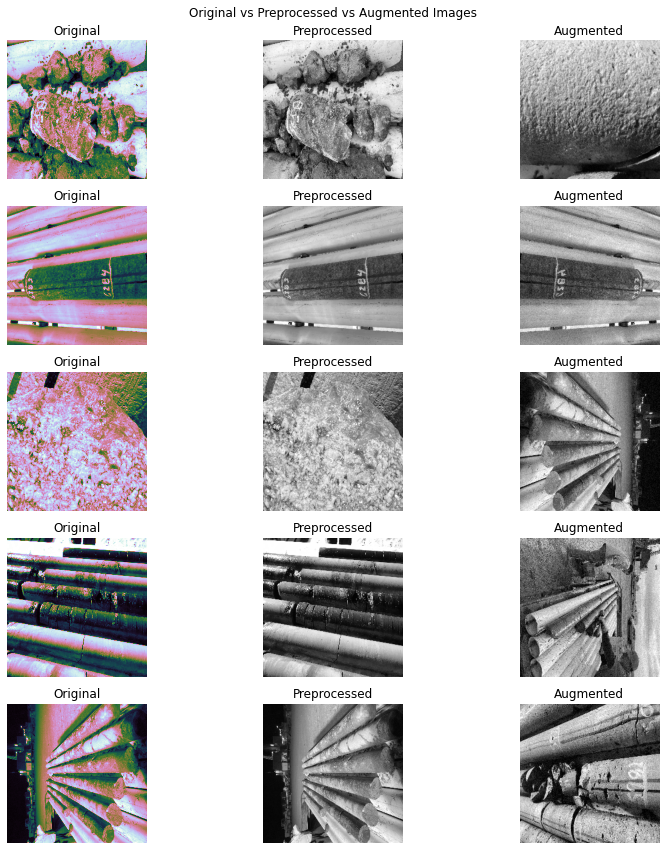

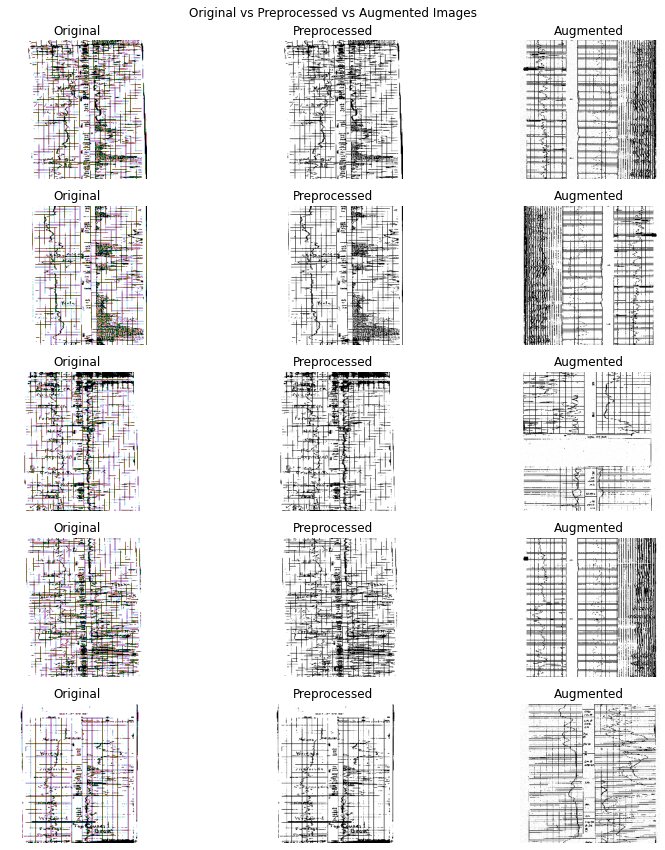

In [405]:
# Visualize original, preprocessed and augmented images for core and logs data
visualize_images(core_images_resized, core_images_resized, augmented_core_images, 'Core Images (Original, Preprocessed, and Augmented)')
visualize_images(logs_images_resized, logs_images_resized, augmented_logs_images, 'Logs Images (Original, Preprocessed, and Augmented)')

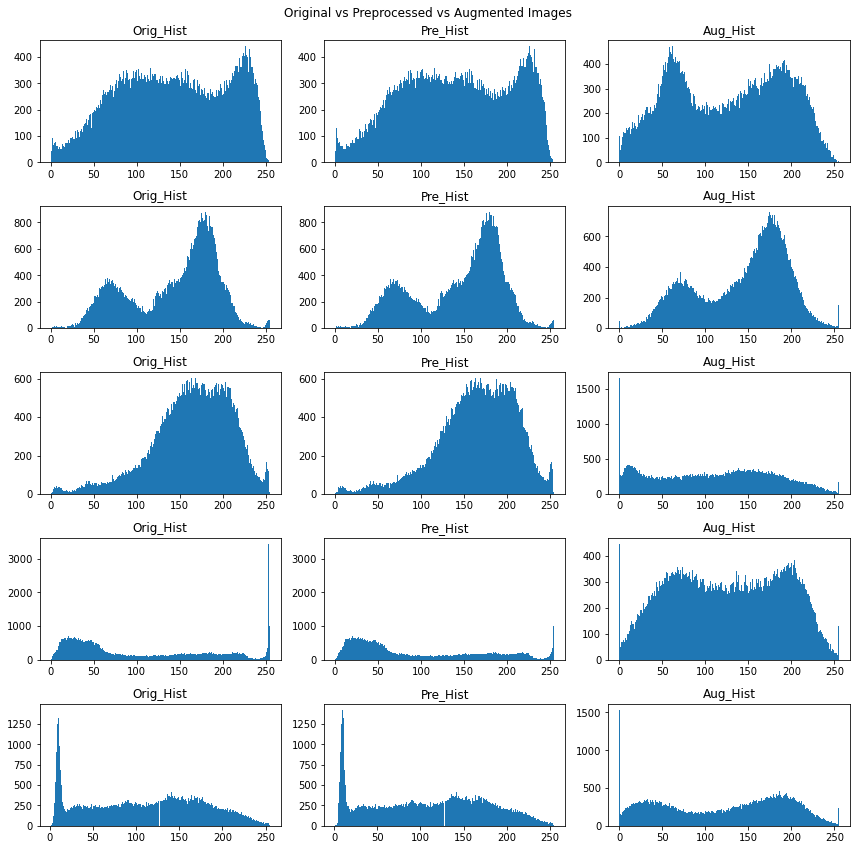

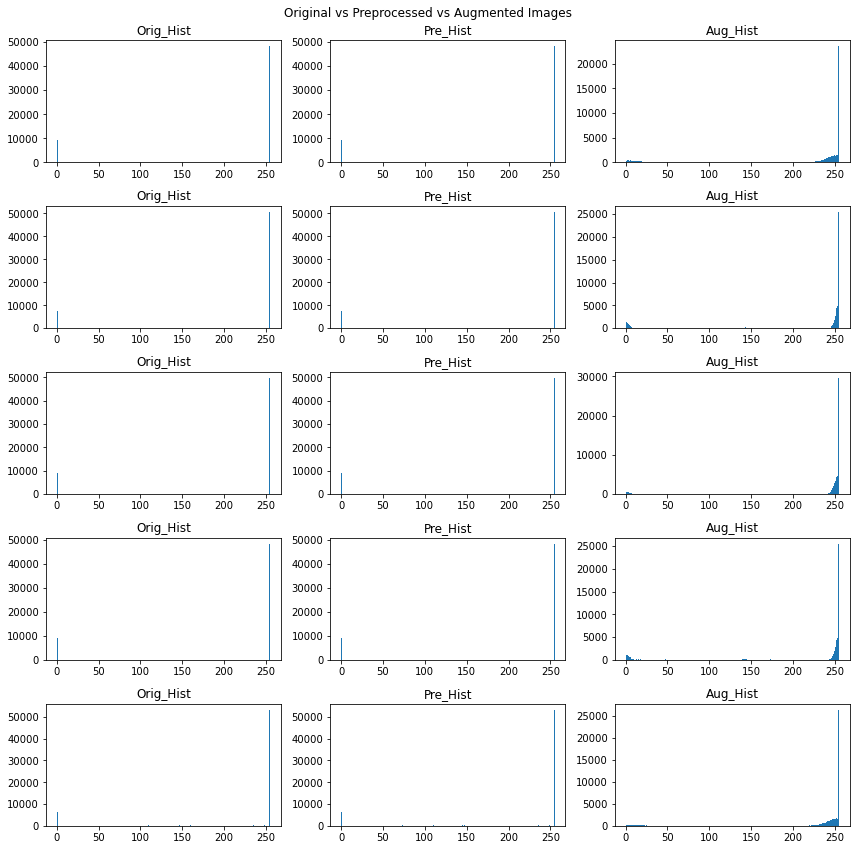

In [406]:
# Visualize original, preprocessed and augmented histogram for core and logs data
visualize_hist(core_images_resized, core_images_resized, augmented_core_images, 'Core Images (Original, Preprocessed, and Augmented)')
visualize_hist(logs_images_resized, logs_images_resized, augmented_logs_images, 'Logs Images (Original, Preprocessed, and Augmented)')

In [401]:
# Generate augmented images and save to output directory
save_core_images = save_augmented_images(augmented_core_images, output_dir_core, "core_image_")
save_logs_images = save_augmented_images(augmented_logs_images, output_dir_logs, "logs_image_")

Saved image core_image__0.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__0.png
Saved image core_image__1.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__1.png
Saved image core_image__2.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__2.png
Saved image core_image__3.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__3.png
Saved image core_image__4.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__4.png
Saved image core_image__5.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__5.png
Saved image core_image__6.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__6.png
Saved image core_image__7.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__7.png
Saved image core_image__8.png to /Users/jexpatel

Saved image core_image__141.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__141.png
Saved image core_image__142.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__142.png
Saved image core_image__143.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__143.png
Saved image core_image__144.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__144.png
Saved image core_image__145.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__145.png
Saved image core_image__146.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__146.png
Saved image core_image__147.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__147.png
Saved image core_image__148.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__148.png
Saved image core

Saved image core_image__278.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__278.png
Saved image core_image__279.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__279.png
Saved image core_image__280.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__280.png
Saved image core_image__281.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__281.png
Saved image core_image__282.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__282.png
Saved image core_image__283.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__283.png
Saved image core_image__284.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__284.png
Saved image core_image__285.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Core/core_image__285.png
Saved image core

Saved image logs_image__37.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__37.png
Saved image logs_image__38.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__38.png
Saved image logs_image__39.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__39.png
Saved image logs_image__40.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__40.png
Saved image logs_image__41.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__41.png
Saved image logs_image__42.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__42.png
Saved image logs_image__43.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__43.png
Saved image logs_image__44.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image_

Saved image logs_image__173.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__173.png
Saved image logs_image__174.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__174.png
Saved image logs_image__175.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__175.png
Saved image logs_image__176.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__176.png
Saved image logs_image__177.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__177.png
Saved image logs_image__178.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__178.png
Saved image logs_image__179.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__179.png
Saved image logs_image__180.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well L

Saved image logs_image__279.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__279.png
Saved image logs_image__280.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__280.png
Saved image logs_image__281.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__281.png
Saved image logs_image__282.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__282.png
Saved image logs_image__283.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__283.png
Saved image logs_image__284.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__284.png
Saved image logs_image__285.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well Logs/logs_image__285.png
Saved image logs_image__286.png to /Users/jexpatel/Desktop/Image Classification/Augmented Dataset/Well L